# 2D CNN

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import ipywidgets as widgets
from ipywidgets import interact
from datetime import datetime
from timeit import default_timer as timer

# Make sure we get reproducible results after each kernel restart
tf.reset_default_graph()
tf.set_random_seed(1337)
np.random.seed(1337)

## Configuration

In [21]:
# General
n_classes = 2
batch_size = 25
epochs = 20
learning_rate = 0.005
data_file = "stl10.pickle"

# Activation function (tanh may not be the best activation function in terms of network performance
# but has advantages when plotting the activation images (due to the limited range))
act_func = tf.nn.tanh

# Regularization (applied to the convolutional layers)
reg_scale = 0.001
regularizer = tf.contrib.layers.l1_regularizer(reg_scale)

# CNN-specific
n_cnn_layers = 3
n_filters = 4
kernel_size = 5
pool_size = 3
pool_stride = 3

## Load data

In [22]:
with open(data_file, "rb") as file:
    data = pickle.load(file)

images = data["images"]
labels = data["labels"]
selected = [100, 700]
selected.extend(list(range(labels.shape[0] - 1, labels.shape[0])))
selected_images = images[selected]
selected_labels = labels[selected]

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=labels.shape[0])
dataset = dataset.batch(batch_size=batch_size)
data_it = dataset.make_initializable_iterator()

example_dataset = tf.data.Dataset.from_tensor_slices((selected_images, selected_labels))
example_dataset = example_dataset.batch(batch_size=selected_labels.shape[0])
example_it = example_dataset.make_initializable_iterator()

## Define network

Epoch: 0	Loss 9464.731	Accuracy 0.320
Epoch: 1	Loss 8047.136	Accuracy 0.320
Epoch: 2	Loss 6250.776	Accuracy 0.400
Epoch: 3	Loss 6162.155	Accuracy 0.360
Epoch: 4	Loss 5547.245	Accuracy 0.320
Epoch: 5	Loss 4150.890	Accuracy 0.360
Epoch: 6	Loss 4156.817	Accuracy 0.240
Epoch: 7	Loss 3036.252	Accuracy 0.360
Epoch: 8	Loss 2187.969	Accuracy 0.440
Epoch: 9	Loss 1276.377	Accuracy 0.560
Epoch: 10	Loss 874.770	Accuracy 0.600
Epoch: 11	Loss 614.948	Accuracy 0.600
Epoch: 12	Loss 365.696	Accuracy 0.520
Epoch: 13	Loss 263.199	Accuracy 0.520
Epoch: 14	Loss 344.553	Accuracy 0.600
Epoch: 15	Loss 496.005	Accuracy 0.480
Epoch: 16	Loss 508.785	Accuracy 0.560
Epoch: 17	Loss 534.412	Accuracy 0.560
Epoch: 18	Loss 513.223	Accuracy 0.640
Epoch: 19	Loss 566.723	Accuracy 0.640


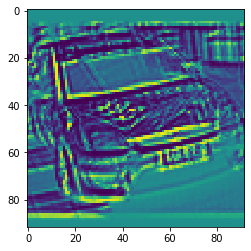

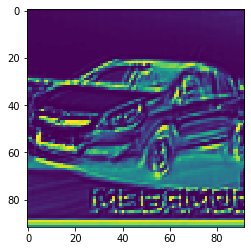

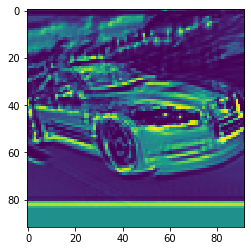

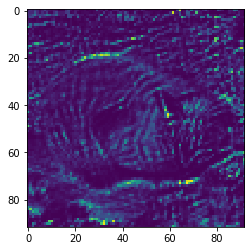

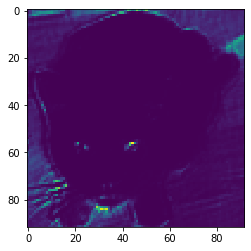

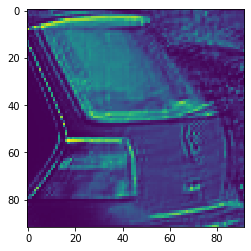

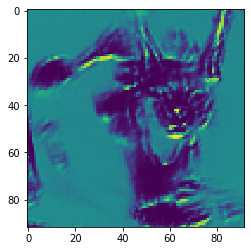

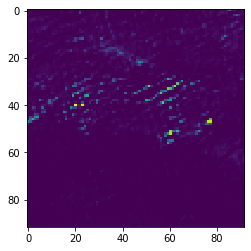

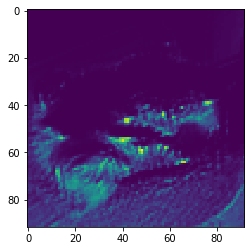

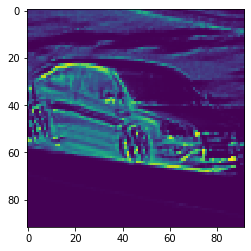

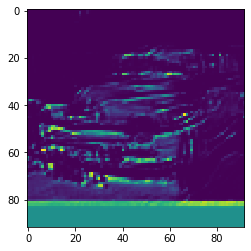

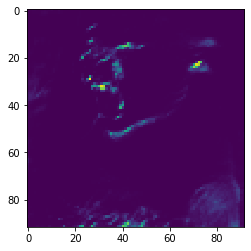

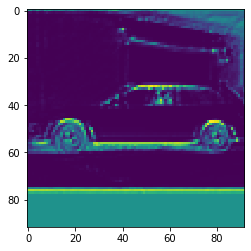

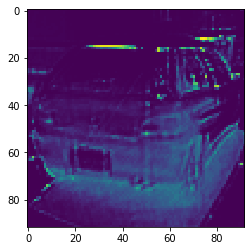

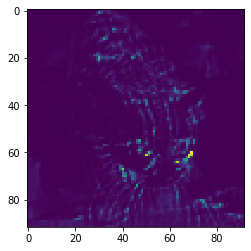

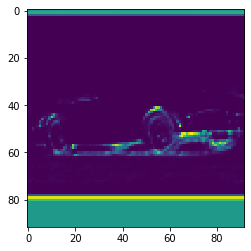

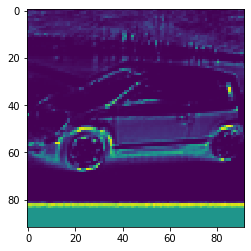

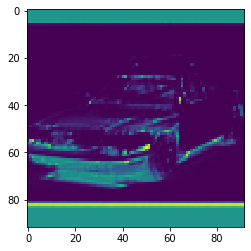

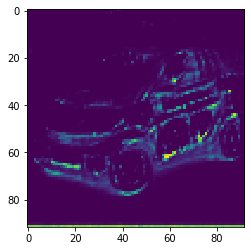

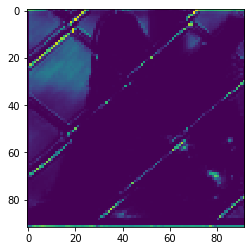

In [23]:
kernel_list = []
    
layers = []
data_in, data_out = data_it.get_next()
for i in range(n_cnn_layers):
    in_tensor = data_in if i == 0 else layers[-1]
    kernel_list.append(tf.Variable(tf.random_normal(shape=(kernel_size, kernel_size, int(in_tensor.shape[-1]), n_filters))))
    layers.append(tf.nn.conv2d(in_tensor, kernel_list[i], strides=(1, 1, 1, 1), padding="VALID", name=("ConvLayer%d" % i)))
    # I assume you want us to use relu???
    layers.append(act_func(layers[i]))
    layers.append(tf.nn.avg_pool(layers[i + 1], ksize=(1, kernel_size, kernel_size, 1), strides=(1, pool_stride, pool_stride, 1), padding="VALID", name=("Pool%d" % i)))
    
flat_dims = layers[-1].shape[1] * layers[-1].shape[2] * layers[-1].shape[3]
layers.append(tf.reshape(layers[-1], (-1, flat_dims)))

fc_weights = tf.Variable(tf.random_normal(shape=(int(layers[-1].shape[-1]), 2)))
bias = tf.Variable(tf.random_normal(shape=(2, )))
layers.append(tf.add(tf.matmul(layers[-1], fc_weights), bias))

reg_term = tf.zeros(shape=(1, ))
for weight in tf.trainable_variables():
    reg_term += regularizer(weights=weight)
    
loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=layers[-1], labels=data_out)) + reg_term
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

classify_correct = tf.cast(tf.equal(tf.argmax(layers[-1], axis=-1), data_out), dtype=tf.int8)
accuracy = tf.divide(tf.reduce_sum(classify_correct), batch_size)

with tf.Session() as sess:
    sess.run(data_it.initializer)
    sess.run(example_it.initializer)
    sess.run(tf.global_variables_initializer())
  
    for epoch in range(epochs):
        plt.figure()
        feature_maps_layer_1 = sess.run(layers[1])
        plt.imshow(feature_maps_layer_1[0, :, :, 0])
        sess.run(optimizer)
        loss_val, acc_val = sess.run((loss, accuracy))
        print("Epoch: %d\tLoss %.3f\tAccuracy %.3f" % (epoch, loss_val, acc_val))
      
        
        
    
    # ding, _ = sess.run(data_it.get_next())
    # plt.imshow(ding[0, :, :, :])
